## Index
* Importing Libraries and DataSet
* Defining Training and Testing Files
* Visualising Normal and Affected X-Rays
* Loading Inception V3 Model 
* Retraining the Model
* Accuracy 
* Testing Model
* Reference:

## Importing Libraries and DataSet

In [0]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

Using TensorFlow backend.


## Importing DataSet (Use your API Username @ "XXXX" and Key @ "YYYYY")

In [0]:
os.environ['KAGGLE_USERNAME'] = "XXXXXX" # username from the json file 
os.environ['KAGGLE_KEY'] = "YYYYYYYYYYYYYYY" # key from the json file
!kaggle datasets download paultimothymooney/chest-xray-pneumonia # api copied from kaggle
!unzip /content/chest-xray-pneumonia.zip
!unzip /content/chest_xray.zip

In [0]:
for dirname in os.walk('/content/chest_xray'):
  print(dirname)

('/content/chest_xray', ['train', 'test', 'val'], ['.DS_Store'])
('/content/chest_xray/train', ['NORMAL', 'PNEUMONIA'], ['.DS_Store'])
('/content/chest_xray/train/NORMAL', [], ['NORMAL2-IM-1111-0001.jpeg', 'NORMAL2-IM-0536-0001.jpeg', 'IM-0141-0001.jpeg', 'IM-0368-0001.jpeg', 'IM-0747-0001.jpeg', 'NORMAL2-IM-1214-0001.jpeg', 'IM-0486-0001.jpeg', 'NORMAL2-IM-0517-0001.jpeg', 'NORMAL2-IM-0539-0001.jpeg', 'NORMAL2-IM-0915-0001.jpeg', 'NORMAL2-IM-0992-0001.jpeg', 'IM-0757-0001.jpeg', 'IM-0695-0001.jpeg', 'NORMAL2-IM-1040-0001.jpeg', 'NORMAL2-IM-1244-0001.jpeg', 'IM-0347-0001.jpeg', 'IM-0421-0001.jpeg', 'NORMAL2-IM-0830-0001.jpeg', 'NORMAL2-IM-1142-0001.jpeg', 'IM-0464-0001.jpeg', 'NORMAL2-IM-1131-0001.jpeg', 'NORMAL2-IM-0587-0001.jpeg', 'NORMAL2-IM-1120-0001.jpeg', 'NORMAL2-IM-1096-0001.jpeg', 'NORMAL2-IM-1289-0001.jpeg', 'NORMAL2-IM-1269-0001.jpeg', 'NORMAL2-IM-0882-0001.jpeg', 'NORMAL2-IM-0746-0001.jpeg', 'IM-0738-0001.jpeg', 'IM-0501-0001.jpeg', 'IM-0633-0001.jpeg', 'IM-0540-0001.jpeg',

## Defining Traning and Testing Files

In [0]:
training_dir = '/content/chest_xray/train'
validation_dir = '/content/chest_xray/test'
test_dir = '/content/chest_xray/val'

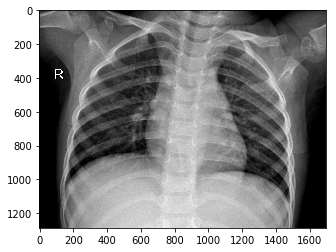

In [0]:
img = mpimg.imread(training_dir + '/NORMAL/NORMAL2-IM-1180-0001.jpeg')
imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Visualising Normal X-Rays

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

      amount += 1

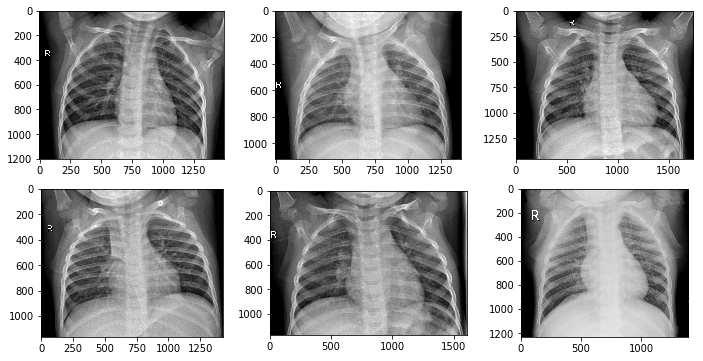

In [0]:
plot_images(training_dir + '/NORMAL')

## Visualising Affected X-Rays

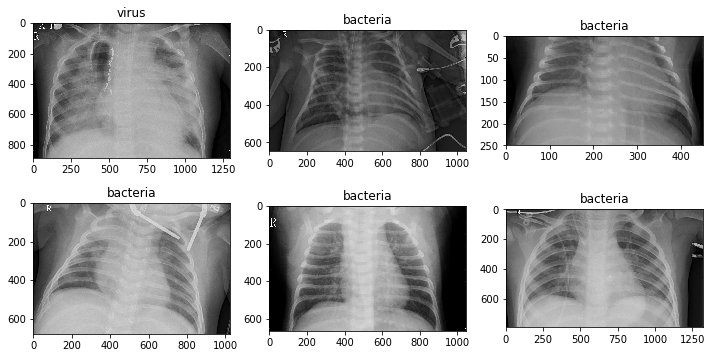

In [0]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

In [0]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Loading Inception V3 Model


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [0]:
model = get_model()









87916544/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________

## Retraining the Model

In [0]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 374s 2s/step - loss: 0.3642 - acc: 0.8639 - val_loss: 2.0993 - val_acc: 0.7003
Epoch 2/5
163/163 [==============================] - 368s 2s/step - loss: 0.2595 - acc: 0.8951 - val_loss: 1.8300 - val_acc: 0.6779
Epoch 3/5
163/163 [==============================] - 368s 2s/step - loss: 0.2546 - acc: 0.8976 - val_loss: 2.8250 - val_acc: 0.6506
Epoch 4/5
163/163 [==============================] - 372s 2s/step - loss: 0.2461 - acc: 0.8986 - val_loss: 2.8239 - val_acc: 0.6410
Epoch 5/5
163/163 [==============================] - 371s 2s/step - loss: 0.2529 - acc: 0.8995 - val_loss: 1.2470 - val_acc: 0.6074


## Accuracy


In [0]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 89ms/step
Loss: 1.6402566856330054
Accuracy: 0.5625


## Testing Model


In [0]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1])]

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 9:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)

      amount += 1

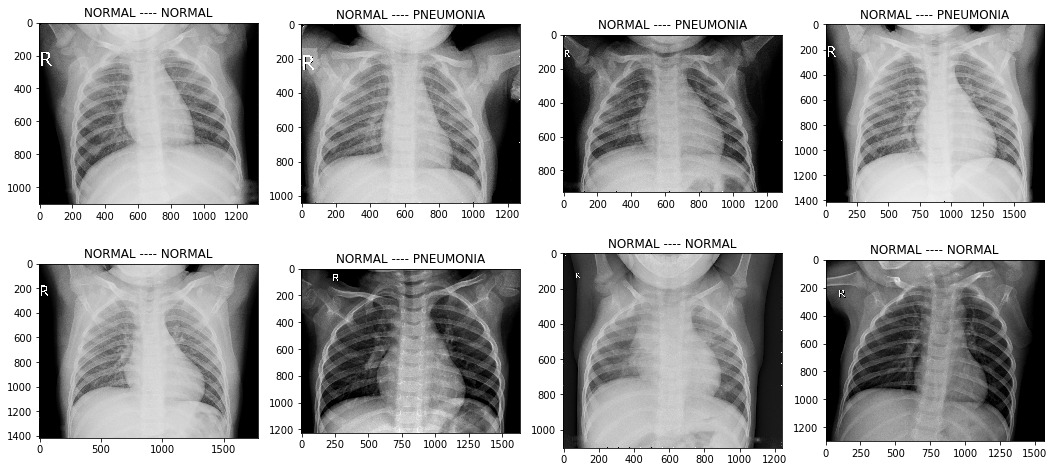

In [0]:
predict_images('/content/chest_xray/val/NORMAL', 'NORMAL')

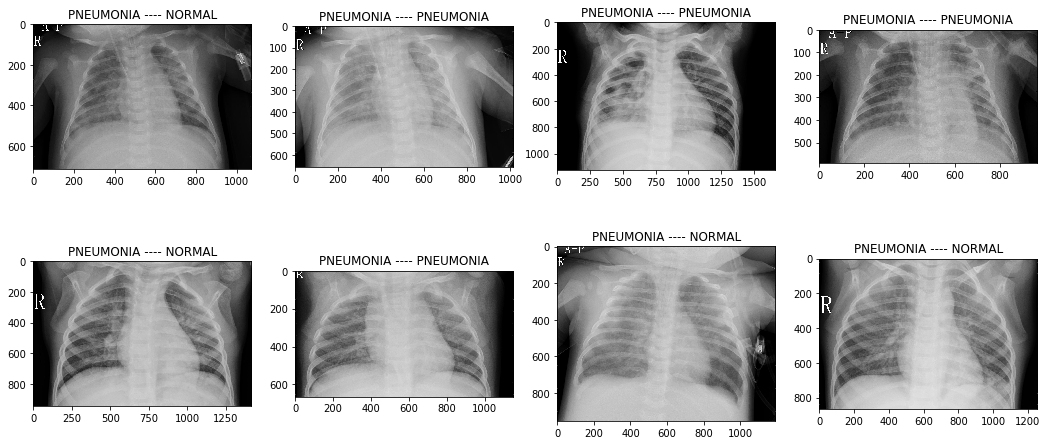

In [0]:
predict_images('/content/chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [0]:
# model.save('awesome_model.h5')
# new_model = keras.models.load_model('awesome_model.h5')

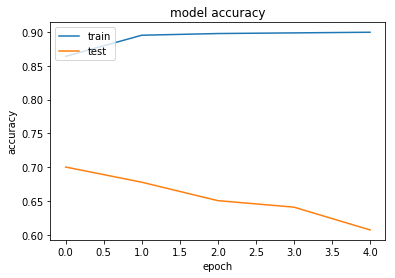

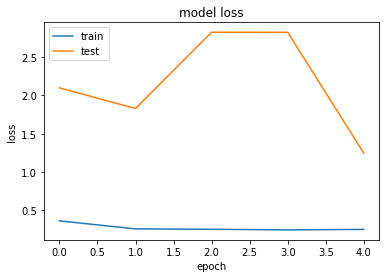

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Reference:
[Deep Learning Demo](https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb)    
[Inception V3](https://keras.io/applications/#inceptionv3)    
[Chest Xray Pneumonia Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)